In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Get data

In [2]:
data = pd.read_csv("files/attacks.csv", encoding='latin1')
data

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2018.06.25,25-Jun-2018,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,...,White shark,"R. Collier, GSAF",2018.06.25-Wolfe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.25,2018.06.25,6303.0,NaN,NaN
1,2018.06.18,18-Jun-2018,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.18-McNeely.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.18,2018.06.18,6302.0,NaN,NaN
2,2018.06.09,09-Jun-2018,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.09-Denges.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.09,2018.06.09,6301.0,NaN,NaN
3,2018.06.08,08-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,...,2 m shark,"B. Myatt, GSAF",2018.06.08-Arrawarra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.08,2018.06.08,6300.0,NaN,NaN
4,2018.06.04,04-Jun-2018,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,...,"Tiger shark, 3m",A .Kipper,2018.06.04-Ramos.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.04,2018.06.04,6299.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25723 entries, 0 to 25722
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Case Number             8702 non-null   object 
 1   Date                    6302 non-null   object 
 2   Year                    6300 non-null   float64
 3   Type                    6298 non-null   object 
 4   Country                 6252 non-null   object 
 5   Area                    5847 non-null   object 
 6   Location                5762 non-null   object 
 7   Activity                5758 non-null   object 
 8   Name                    6092 non-null   object 
 9   Sex                     5737 non-null   object 
 10  Age                     3471 non-null   object 
 11  Injury                  6274 non-null   object 
 12  Fatal (Y/N)             5763 non-null   object 
 13  Time                    2948 non-null   object 
 14  Species                 3464 non-null 

## Data cleaning

In [4]:
data = data.drop_duplicates() #to remove duplicated rows

In [5]:
data.columns = [col.lower().replace(' ','_') for col in data.columns] #to standardize headers

In [6]:
data.rename(columns={"sex_": "gender", "species_": "species", "fatal_(y/n)": "fatal"}, inplace=True)

In [7]:
## dataframe has no duplicates, headers are standardized and we removed rows with lot of NaNs. Let's take another look at our dataframe: 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6312 entries, 0 to 25722
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   case_number             6310 non-null   object 
 1   date                    6302 non-null   object 
 2   year                    6300 non-null   float64
 3   type                    6298 non-null   object 
 4   country                 6252 non-null   object 
 5   area                    5847 non-null   object 
 6   location                5762 non-null   object 
 7   activity                5758 non-null   object 
 8   name                    6092 non-null   object 
 9   gender                  5737 non-null   object 
 10  age                     3471 non-null   object 
 11  injury                  6274 non-null   object 
 12  fatal                   5763 non-null   object 
 13  time                    2948 non-null   object 
 14  species                 3464 non-null  

We can already notice that several columns won't be important for our model: 
- case_number doesn't add any relevant information. same for the date, year, case_number.1, case_number.2, original_order as the information from those originates in the date
- type contains very unclear information
- name and investigator_or_source columns - to be dropped, they don't contain any information applicable for our model 
- same for pdf, href and href_formula which contain pdf with links 
I will focus on the data regarding location, activity, gender of the victim and injury/fatality of the attack. 

In [8]:
## The initial analysis suggests we can already drop several columns: case_number, year, name, pdf, href_formula, href, case_number.1, case_number.2, original_order, unnamed:_22, unnamed:_23, investigator_or_source
data = data.drop(columns = ["case_number", "date", "year", "type", "name", "age", "time", "pdf", "href_formula", "href", "case_number.1", "case_number.2", "original_order", "unnamed:_22", "unnamed:_23", "investigator_or_source"], axis=1)

In [9]:
def clean_empty(x):
    return 'UNK' if x == '' or x == ' ' else x

In [10]:
for col in data.select_dtypes('object'):
    data[col] = data[col].apply(clean_empty)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6312 entries, 0 to 25722
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   country   6252 non-null   object
 1   area      5847 non-null   object
 2   location  5762 non-null   object
 3   activity  5758 non-null   object
 4   gender    5737 non-null   object
 5   injury    6274 non-null   object
 6   fatal     5763 non-null   object
 7   species   3464 non-null   object
dtypes: object(8)
memory usage: 443.8+ KB


In [12]:
data = data.dropna(thresh=5) #to remove rows which have NaN in min. 5 columns 

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6201 entries, 0 to 6301
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   country   6178 non-null   object
 1   area      5833 non-null   object
 2   location  5749 non-null   object
 3   activity  5726 non-null   object
 4   gender    5680 non-null   object
 5   injury    6183 non-null   object
 6   fatal     5684 non-null   object
 7   species   3443 non-null   object
dtypes: object(8)
memory usage: 436.0+ KB


We have only categorical data left. 

In [14]:
data1 = data.copy() #copy of the dataframe after initial clean up

### Dealing with NaNs (except geo columns which I will treat later)

In [15]:
data1.isna().sum()

country       23
area         368
location     452
activity     475
gender       521
injury        18
fatal        517
species     2758
dtype: int64

In [16]:
data1["activity"] = data1["activity"].fillna("ukn")

In [17]:
data1["gender"] = data1["gender"].fillna("ukn")

In [18]:
data1["injury"] = data1["injury"].fillna("ukn")

In [19]:
data1["fatal"] = data1["fatal"].fillna("ukn")

In [20]:
data1["species"] = data1["species"].fillna("ukn")

In [21]:
data1.isna().sum()

country      23
area        368
location    452
activity      0
gender        0
injury        0
fatal         0
species       0
dtype: int64

In [22]:
data2 = data1.copy() #copy of the dataframe after removing NaNs

In [23]:
data2.describe()

,country,area,location,activity,gender,injury,fatal,species
count,6178,5833,5749,6201,6201,6201,6201,6201
unique,209,821,4097,1519,7,3698,9,1550
top,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,M,FATAL,N,ukn
freq,2227,1037,163,969,5039,778,4255,2758


In [24]:
for col in data2:
    print(data2[col].value_counts(), '\n')

USA                       2227
AUSTRALIA                 1332
SOUTH AFRICA               579
PAPUA NEW GUINEA           133
NEW ZEALAND                126
                          ... 
NORTH SEA                    1
RED SEA / INDIAN OCEAN       1
BRITISH WEST INDIES          1
ADMIRALTY ISLANDS            1
CEYLON (SRI LANKA)           1
Name: country, Length: 209, dtype: int64 

Florida                   1037
New South Wales            485
Queensland                 310
Hawaii                     298
California                 290
                          ... 
Aulong Island                1
Antibes                      1
Illeginni Atoll              1
Between Beira & Maputo       1
Moala Island                 1
Name: area, Length: 821, dtype: int64 

New Smyrna Beach, Volusia County                  163
Daytona Beach, Volusia County                      30
Ponce Inlet, Volusia County                        20
Melbourne Beach, Brevard County                    18
Myrtle Beach, Horry

Looking at the information above we can see that our columns contain way too many values. We need to clean them so it's more clear for the model we'll build. 

### Cleaning the gender column. 

In [25]:
data2["gender"].value_counts()

M      5039
F       635
ukn     521
M         2
N         2
lli       1
.         1
Name: gender, dtype: int64

In [26]:
def clean_gender(x):
    x = str(x).lower()
    if x.startswith("m"):
        return "m"
    elif x.startswith ("f"):
        return "f"
    elif x.startswith("n"):
        return "m"
    else: 
        return "ukn"

In [27]:
data2["gender"] = data2["gender"].apply(clean_gender)
data2["gender"].value_counts()

m      5043
f       635
ukn     523
Name: gender, dtype: int64

### Cleaning the activity column

In the activity column we have too many different values so too avoid problems with our model I'll bucket the ones with a very low count (often it's too precise explanation of the context when the incident took place) under the label "other"

In [28]:
data2["activity"].value_counts()

Surfing                                 969
Swimming                                866
ukn                                     475
Fishing                                 430
Spearfishing                            331
                                       ... 
Feeding mullet to sharks                  1
Sight-seeing                              1
Netting pilchards                         1
Surf-fishing                              1
Wreck of  large double sailing canoe      1
Name: activity, Length: 1519, dtype: int64

In [29]:
def clean_activity(x):
    x = str(x).lower()
    if "surfing" in x:
        return "surfing"
    elif "swimming" in x:
        return "swimming"
    elif "fishing" in x:
        return "fishing"
    elif "spearfishing" in x:
        return "fishing"
    elif "bathing" in x:
        return "bathing"
    elif "diving" in x:
        return "diving"
    elif "surf-skiing" in x:
        return "surf skiing"
    elif "surf skiing" in x:
        return "surf skiing"
    elif "boat" in x:
        return "boating"
    elif "stand-up paddleboarding" in x:
        return "paddle boarding"
    elif "sitting on surfboard" in x:
        return "surfing"
    elif "floating on his back" in x:
        return "floating"
    elif "floating in inner tube" in x:
        return "floating"
    elif "fell overboard" in x:
        return "fell into the water"
    else: 
        return x

In [30]:
data2["activity"] = data2["activity"].apply(clean_activity)
data2["activity"].value_counts()

fishing                                 1157
surfing                                 1134
swimming                                1107
diving                                   524
ukn                                      475
                                        ... 
attempting to anesthetize shark            1
walking on reef                            1
aircraft exploded                          1
paddling rescue ski                        1
wreck of  large double sailing canoe       1
Name: activity, Length: 695, dtype: int64

In [31]:
rare_activities = [ind for ind, val in data2["activity"].value_counts().iteritems()if val <5]
rare_activities

['paddling on surfboard',
 'jumping',
 'clamming',
 'splashing',
 'body-boarding',
 'kite boarding',
 'lifesaving drill',
 'jumped into the water',
 'air disaster',
 'feeding sharks',
 'seine netting',
 'tagging sharks',
 'paddling',
 'playing in the surf',
 '.',
 'their 9 m launch was run down by a 25,000-ton japanese freighter  on the night of 3-11-1977 & they drifted, clinging to an icebox for 2 days',
 'jumped overboard',
 'shark watching',
 'knocked overboard',
 'spearing fish',
 'feeding fish',
 'sculling',
 'floating on a raft',
 'escaping from alacatraz',
 'unknown',
 'competing in the woodvale atlantic rowing race',
 'sup',
 'wreck of the schooner pohoiki ',
 'jumped overboard ',
 'standing in knee-deep water',
 'crabbing',
 'suicide',
 'thrown overboard',
 'cruising',
 'shark tagging',
 'shooting sharks ',
 'rowing ',
 'finning the shark that bit him',
 '"flying tiger" transport plane went down with 5 men onboard',
 'the christie v sank on 11/6/1988, survivors were adrift on 

Before we bucket them let's take a moment to appreciate the bravery of few of those shark attack victims who were attacked while: 
- dragging a shark
- diving naked into the water on a bet
- attempting to catch a crocodile
- attempting to lasso a shark
- attempting to rescue a shark
- kissing a shark
- defecating in water beneath the docks
- dragging banana seeds through the shallows
- put foot inside mouth of supposedly dead shark. 

In [32]:
data2["activity"] = data2["activity"].apply(lambda x: "other" if x in rare_activities else x) #I assign "other" label to activities with low count (<5)
data2["activity"].value_counts()

fishing                       1157
surfing                       1134
swimming                      1107
other                          776
diving                         524
ukn                            475
bathing                        189
wading                         149
boating                        103
standing                        99
snorkeling                      89
body boarding                   64
fell into the water             62
boogie boarding                 45
kayaking                        33
treading water                  32
surf skiing                     31
floating                        24
walking                         17
paddle boarding                 15
canoeing                        14
sea disaster                    13
rowing                          12
sailing                          9
playing                          7
shipwreck                        6
murder                           5
paddleskiing                     5
dangling feet in the

In [33]:
data3 = data2.copy() #copy of the dataframe after cleaning gender and activity columns

### Cleaning injury column

In [34]:
data3["injury"].value_counts()

FATAL                                                                   778
Survived                                                                 95
Foot bitten                                                              87
No injury                                                                81
Leg bitten                                                               72
                                                                       ... 
FATAL, arm bitten                                                         1
Multiple injuries                                                         1
Right thigh bitten PROVOKED INCIDENT                                      1
Bruised right leg                                                         1
FATAL. "Shark bit him in half, carrying away the lower extremities"       1
Name: injury, Length: 3698, dtype: int64

In [35]:
def clean_injury(x):
    x = str(x).lower()
    if "fatal" in x:
        return "fatal"
    elif "leg" in x:
        return "leg or foot injury"
    elif "thigh" in x:
        return "leg or foot injury"
    elif "knee" in x:
        return "leg or foot injury"
    elif "foot" in x:
        return "leg or foot injury"
    elif "feet" in x:
        return "leg or foot injury"
    elif "heel" in x:
        return "leg or foot injury"
    elif "ankle" in x:
        return "leg or foot injury"
    elif "shin" in x:
        return "leg or foot injury"
    elif "toe" in x:
        return "leg or foot injury"
    elif "calf" in x:
        return "leg or foot injury"
    elif "calves" in x:
        return "leg or foot injury"
    elif "human remains" in x:
        return "fatal"
    elif "bones recovered" in x:
        return "fatal"
    elif "body not recovered" in x:
        return "fatal"
    elif "body recovered" in x:
        return "fatal"
    elif "remains recovered" in x:
        return "fatal"
    elif "killed" in x:
        return "fatal"
    elif "laceration" in x:
        return "lacerations"
    elif "lacerated" in x:
        return "lacerations"
    elif "abdomen" in x:
        return "torso injury"
    elif "hand" in x:
        return "arm or hand injury"
    elif "finger" in x:
        return "arm or hand injury"
    elif "thumb" in x:
        return "arm or hand injury"
    elif "arm" in x:
        return "arm or hand injury"
    elif "shoulder" in x:
        return "arm or hand injury"
    elif "elbow" in x:
        return "arm or hand injury"
    elif "wrist" in x:
        return "arm or hand injury"
    elif "head" in x:
        return "head or face injury"
    elif "face" in x:
        return "head or face injury"
    elif "scalp" in x:
        return "head or face injury"
    elif "chest" in x:
        return "torso injury"
    elif "ribs" in x:
        return "torso injury"
    elif "back" in x:
        return "torso injury"
    elif "torso" in x:
        return "torso injury"
    elif "hip" in x:
        return "torso injury"
    elif "buttock" in x:
        return "torso injury"
    elif "no injury" in x:
        return "no injury"
    elif "no injuries" in x:
        return "no injury"
    elif "not injured" in x:
        return "no injury"
    elif "uninjured" in x:
        return "no injury"
    elif "swim fin bitten" in x:
        return "no injury"
    elif "minor" in x:
        return "minor injury"
    elif "bruise" in x:
        return "minor injury"
    elif "abrasion" in x:
        return "minor injury"
    elif "survived" in x:
        return "other"
    elif "drown" in x:
        return "shark involvement unconfirmed"
    elif "scaveng" in x:
        return "scavenging"
    elif "not confirmed" in x:
        return "shark involvement unconfirmed"
    elif "unconfirmed" in x:
        return "shark involvement unconfirmed"
    elif "post-mortem" in x:
        return "shark involvement unconfirmed"
    elif "post mortem" in x:
        return "shark involvement unconfirmed"
    elif "no details" in x:
        return "unknown"
    elif "provoked incident" in x:
        return "unknown"
    elif "ukn" in x:
        return "unknown"
    else: 
        return x

In [36]:
data3["injury"] = data3["injury"].apply(clean_injury)

In [37]:
data3["injury"].value_counts()

leg or foot injury                                                                      2317
fatal                                                                                   1400
no injury                                                                                763
arm or hand injury                                                                       534
lacerations                                                                              413
                                                                                        ... 
cracked jaw & broken tooth, shark took chunk out of surfboard                              1
the press reported this as an attack by a white shark but the diver was the agressor       1
shark bit rudder & hull                                                                    1
major injuries                                                                             1
shark bumped him                                                      

In [38]:
other_injuries = [ind for ind, val in data3["injury"].value_counts().iteritems()if val <6]
other_injuries

['recovered',
 'missing, believed taken by a shark',
 'thought to have been taken by a shark. body was not recovered',
 'multiple injuries',
 'multiple major injuries',
 'missing, thought to have been taken by a shark',
 'of her crew of 50, eight perished, including the two injured men',
 'survivors on life rafts were harassed by sharks',
 'paddle of surf ski bitten by shark',
 'general imamura, commander in chief of japanese forces in java was sentenced to 10 years imprisonment by australian military court for his role in the "pig basket atrocities"',
 'injured by sharks, but managed to swim ashore 6.5 hours later',
 'no inury to occupants, shark struck boat',
 'clothing torn by sharks',
 'struck by shark immediately before it bit tanner (see below)',
 'an estimated  3,000 to 7,000 japanese troops perished, some were taken by sharks',
 '"mauled"',
 'shark leapt onboard & into fishwell, tossing a crew member, pepino, in the sea',
 'disappeared & his torn clothing washed ashore',
 'shar

There were some happy endings: 
- 'reported to have been killed by a shark but 2 years later he was found very much alive'
- 'later found to be fiction, never happened'
- 'never happened; it was a  hoax' 

In [39]:
data3["injury"] = data3["injury"].apply(lambda x: "other" if x in other_injuries else x) #I gather all injuries with frequency lower than 6 under one label "other"
data3["injury"].value_counts()

leg or foot injury               2317
fatal                            1400
no injury                         763
arm or hand injury                534
lacerations                       413
other                             308
shark involvement unconfirmed     119
unknown                           117
torso injury                      104
minor injury                       74
head or face injury                40
scavenging                         12
Name: injury, dtype: int64

In [40]:
data4 = data3.copy()

### Cleaning fatal column

In [41]:
data4["fatal"].value_counts()

N          4255
Y          1358
ukn         517
UNKNOWN      60
 N            7
M             1
2017          1
N             1
y             1
Name: fatal, dtype: int64

In [42]:
def clean_fatal(x):
    x = str(x).lower()
    if x.startswith("y"):
        return "y"
    elif x.startswith("n"):
        return "n"
    else: 
        return "ukn"

In [43]:
data4["fatal"] = data4["fatal"].apply(clean_fatal)
data4["fatal"].value_counts()

n      4256
y      1359
ukn     586
Name: fatal, dtype: int64

Let's check if we can identify whether the injury was fatal or not based on the values in injury column

In [44]:
data4.loc[data4["injury"].str.contains ("fatal"), "fatal"] = "y"

In [45]:
data4["fatal"].value_counts()

n      4244
y      1469
ukn     488
Name: fatal, dtype: int64

In [48]:
data4["fatal"] = data4["fatal"].apply(clean_fatal) #applying the function to clean the values 
data4 = data4[data4.fatal != "ukn"] #removing rows where we don't know if the attack was fatal
data4["fatal"].value_counts().to_frame()

,fatal
n,4244
y,1469


### Species column - following the value count check I decided to drop them

In [49]:
data4["species"].value_counts()

ukn                                                                                                                              2700
White shark                                                                                                                       158
Tiger shark                                                                                                                        73
Bull shark                                                                                                                         51
6' shark                                                                                                                           40
                                                                                                                                 ... 
1 m shark, possibly whitetip reef shark                                                                                             1
Possibly a 1.5 m [5'] blacktip or spinner shark               

In [50]:
# species columns seems to contain a lot of incoherent or unconfirmed data so I will drop this column. 
data4 = data4.drop(columns = ["species"], axis=1)

In [51]:
data5 = data4.copy()

### Cleaning geographical columns

#### Country

In [52]:
data5.isna().sum() #let's deal with NaN in geographical columns

country      22
area        342
location    418
activity      0
gender        0
injury        0
fatal         0
dtype: int64

In [53]:
# I will look at the country column where we miss the information and I will try to fill it based on the information in two other columns:
filtered_columns = ["country", "location", "area"]
filtered_data = data5[data5["country"].isna()]
result = filtered_data[filtered_columns]
result

,country,location,area
2956,NaN,NaN,English Channel
3395,NaN,NaN,NaN
3399,NaN,NaN,NaN
3605,NaN,Florida Strait,NaN
4231,NaN,NaN,Near the Andaman & Nicobar Islands
4266,NaN,Geyser Bank,Between Comores & Madagascar
4498,NaN,Between Cuba & Costa Rica,Caribbean Sea
4639,NaN,225 miles east of Hong Kong,NaN
4700,NaN,NaN,Off South American coast
4712,NaN,NaN,300 miles east of St. Thomas (Virgin Islands)


In [54]:
data5.loc[data5["area"] == ("English Channel"), "country"] = "Great Britain"

In [55]:
data5.loc[data5["location"] == ("Between St. Kitts & Nevis"), "country"] = "Saint Kitts and Nevis"

In [56]:
data5.loc[data5["location"] == ("Florida Strait"), "country"] = "USA"

In [57]:
data5.loc[data5["area"] == ("Near the Andaman & Nicobar Islands"), "country"] = "India"

In [58]:
data5.loc[data5["location"] == ("Geyser Bank"), "country"] = "France"

In [59]:
data5.loc[data5["location"] == ("Between Cuba & Costa Rica"), "country"] = "Cuba"

In [60]:
data5.loc[data5["location"] == ("225 miles east of Hong Kong"), "country"] = "China"

In [61]:
data5.loc[data5["area"] == ("300 miles east of St. Thomas (Virgin Islands)"), "country"] = "USA"

In [62]:
data5.loc[data5["location"] == ("Île Saint-Paul"), "country"] = "France"

In [63]:
data5.loc[data5["area"] == ("Gulf of California"), "country"] = "Mexico"

In [64]:
data5.loc[data5["location"] == ("Santa Cruz"), "country"] = "USA"

In [65]:
data5.loc[data5["area"] == ("St Helena"), "country"] = "Great Britain"

In [66]:
data5.loc[data5["location"] == ("Carlisle Bay"), "country"] = "Barbados"

In [67]:
filtered_columns = ["country", "location", "area"]
filtered_data = data5[data5["country"].isna()]
result = filtered_data[filtered_columns]
result

,country,location,area
3395,NaN,NaN,NaN
3399,NaN,NaN,NaN
4498,NaN,Between Cuba & Costa Rica,Caribbean Sea
4700,NaN,NaN,Off South American coast
5425,NaN,Near the equator,NaN
5612,NaN,NaN,Mediterranean Sea
5808,NaN,NaN,Western Banks
6131,NaN,NaN,NaN
6175,NaN,NaN,Ionian Sea
6177,NaN,NaN,Ionian Sea


In [68]:
data5.dropna(subset=["country"], inplace=True) # I remove the rows which don't have the information for country and where the country can't be identified based on the location or area.

In [69]:
data5.isna().sum()

country       0
area        337
location    410
activity      0
gender        0
injury        0
fatal         0
dtype: int64

In [70]:
data5["country"].value_counts().to_frame()

,country
USA,2056
AUSTRALIA,1222
SOUTH AFRICA,527
PAPUA NEW GUINEA,130
NEW ZEALAND,115
...,...
MALDIVE ISLANDS,1
NICARAGUA,1
NORTH SEA,1
ARUBA,1


In [71]:
def clean_country(x):
    x = str(x).lower()
    if "england" in x:
        return "united kingdom"
    elif "great britain" in x:
        return "united kingdom"
    elif "scotland" in x:
        return "united kingdom"
    elif "new caledonia" in x:
        return "france"
    elif "reunion" in x:
        return "france"
    elif "hong kong" in x:
        return "china"
    elif "ceylon" in x:
        return "sri lanka"
    elif "solomon" in x:
        return "solomon islands"
    elif "ocean" in x:
        return "delete"
    elif "sea" in x:
        return "delete"
    elif "?" in x:
        return "delete"
    elif "between" in x:
        return "delete"
    elif "/" in x:
        return "delete"
    else: 
        return x

In [72]:
data5["country"] = data5["country"].apply(clean_country) #applying the function to clean the values 
data5 = data5[data5.country != "delete"] #removing rows where country was labales as to be deleted
data5["country"].value_counts().to_frame() #checking the value count - we still have way too many variables

,country
usa,2056
australia,1222
south africa,527
papua new guinea,130
france,120
...,...
northern mariana islands,1
java,1
philippines,1
bay of bengal,1


In [73]:
# I will remove the data from countries in which less than 15 shark attacks were registered

In [74]:
data6 = data5.copy()

In [75]:
counts = data6["country"].value_counts()
data6 = data6.loc[data6["country"].isin(counts.index[counts>15])]
data6["country"].value_counts().to_frame()

,country
usa,2056
australia,1222
south africa,527
papua new guinea,130
france,120
new zealand,115
bahamas,103
brazil,100
mexico,79
fiji,61


In [76]:
data6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5128 entries, 0 to 6301
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   country   5128 non-null   object
 1   area      4948 non-null   object
 2   location  4875 non-null   object
 3   activity  5128 non-null   object
 4   gender    5128 non-null   object
 5   injury    5128 non-null   object
 6   fatal     5128 non-null   object
dtypes: object(7)
memory usage: 320.5+ KB


### Location and area columns - following the clean up done on country column, I will remove those two columns 

In [77]:
data6["area"].value_counts()

Florida             975
New South Wales     443
Queensland          287
Hawaii              265
California          264
                   ... 
Saint-Louis           1
Tokyo Prefecture      1
Manfredonia           1
Viscayan Sea          1
North Carolina        1
Name: area, Length: 493, dtype: int64

In [78]:
data6["location"].value_counts()

New Smyrna Beach, Volusia County                          160
Daytona Beach, Volusia County                              30
Ponce Inlet, Volusia County                                20
Melbourne Beach, Brevard County                            17
Myrtle Beach, Horry County                                 16
                                                         ... 
Fort Pierce Inlet, St. Lucie County                         1
World Typhoon Lagoon, Disney Water Park, Orange County      1
Fort Fisher, New Hanover County                             1
Grand Strand, Myrtle Beach, Horry County                    1
Below the English fort, Trincomalee                         1
Name: location, Length: 3439, dtype: int64

In [79]:
data6 = data6.drop(columns = ["area", "location"], axis=1) #once I used the data in location and area columns to fill the missing country information I will remove those columns as they contain too many values (I consider country information to be sufficient for the model) 

In [80]:
data_final = data6.copy()
data_final

,country,activity,gender,injury,fatal
0,usa,other,f,no injury,n
1,usa,standing,f,leg or foot injury,n
2,usa,surfing,m,leg or foot injury,n
3,australia,surfing,m,leg or foot injury,n
4,mexico,diving,m,leg or foot injury,n
...,...,...,...,...,...
6297,australia,diving,m,fatal,y
6298,australia,diving,m,fatal,y
6299,usa,swimming,m,fatal,y
6300,panama,ukn,m,fatal,y


## EDA

### Countplots to see the data distribution

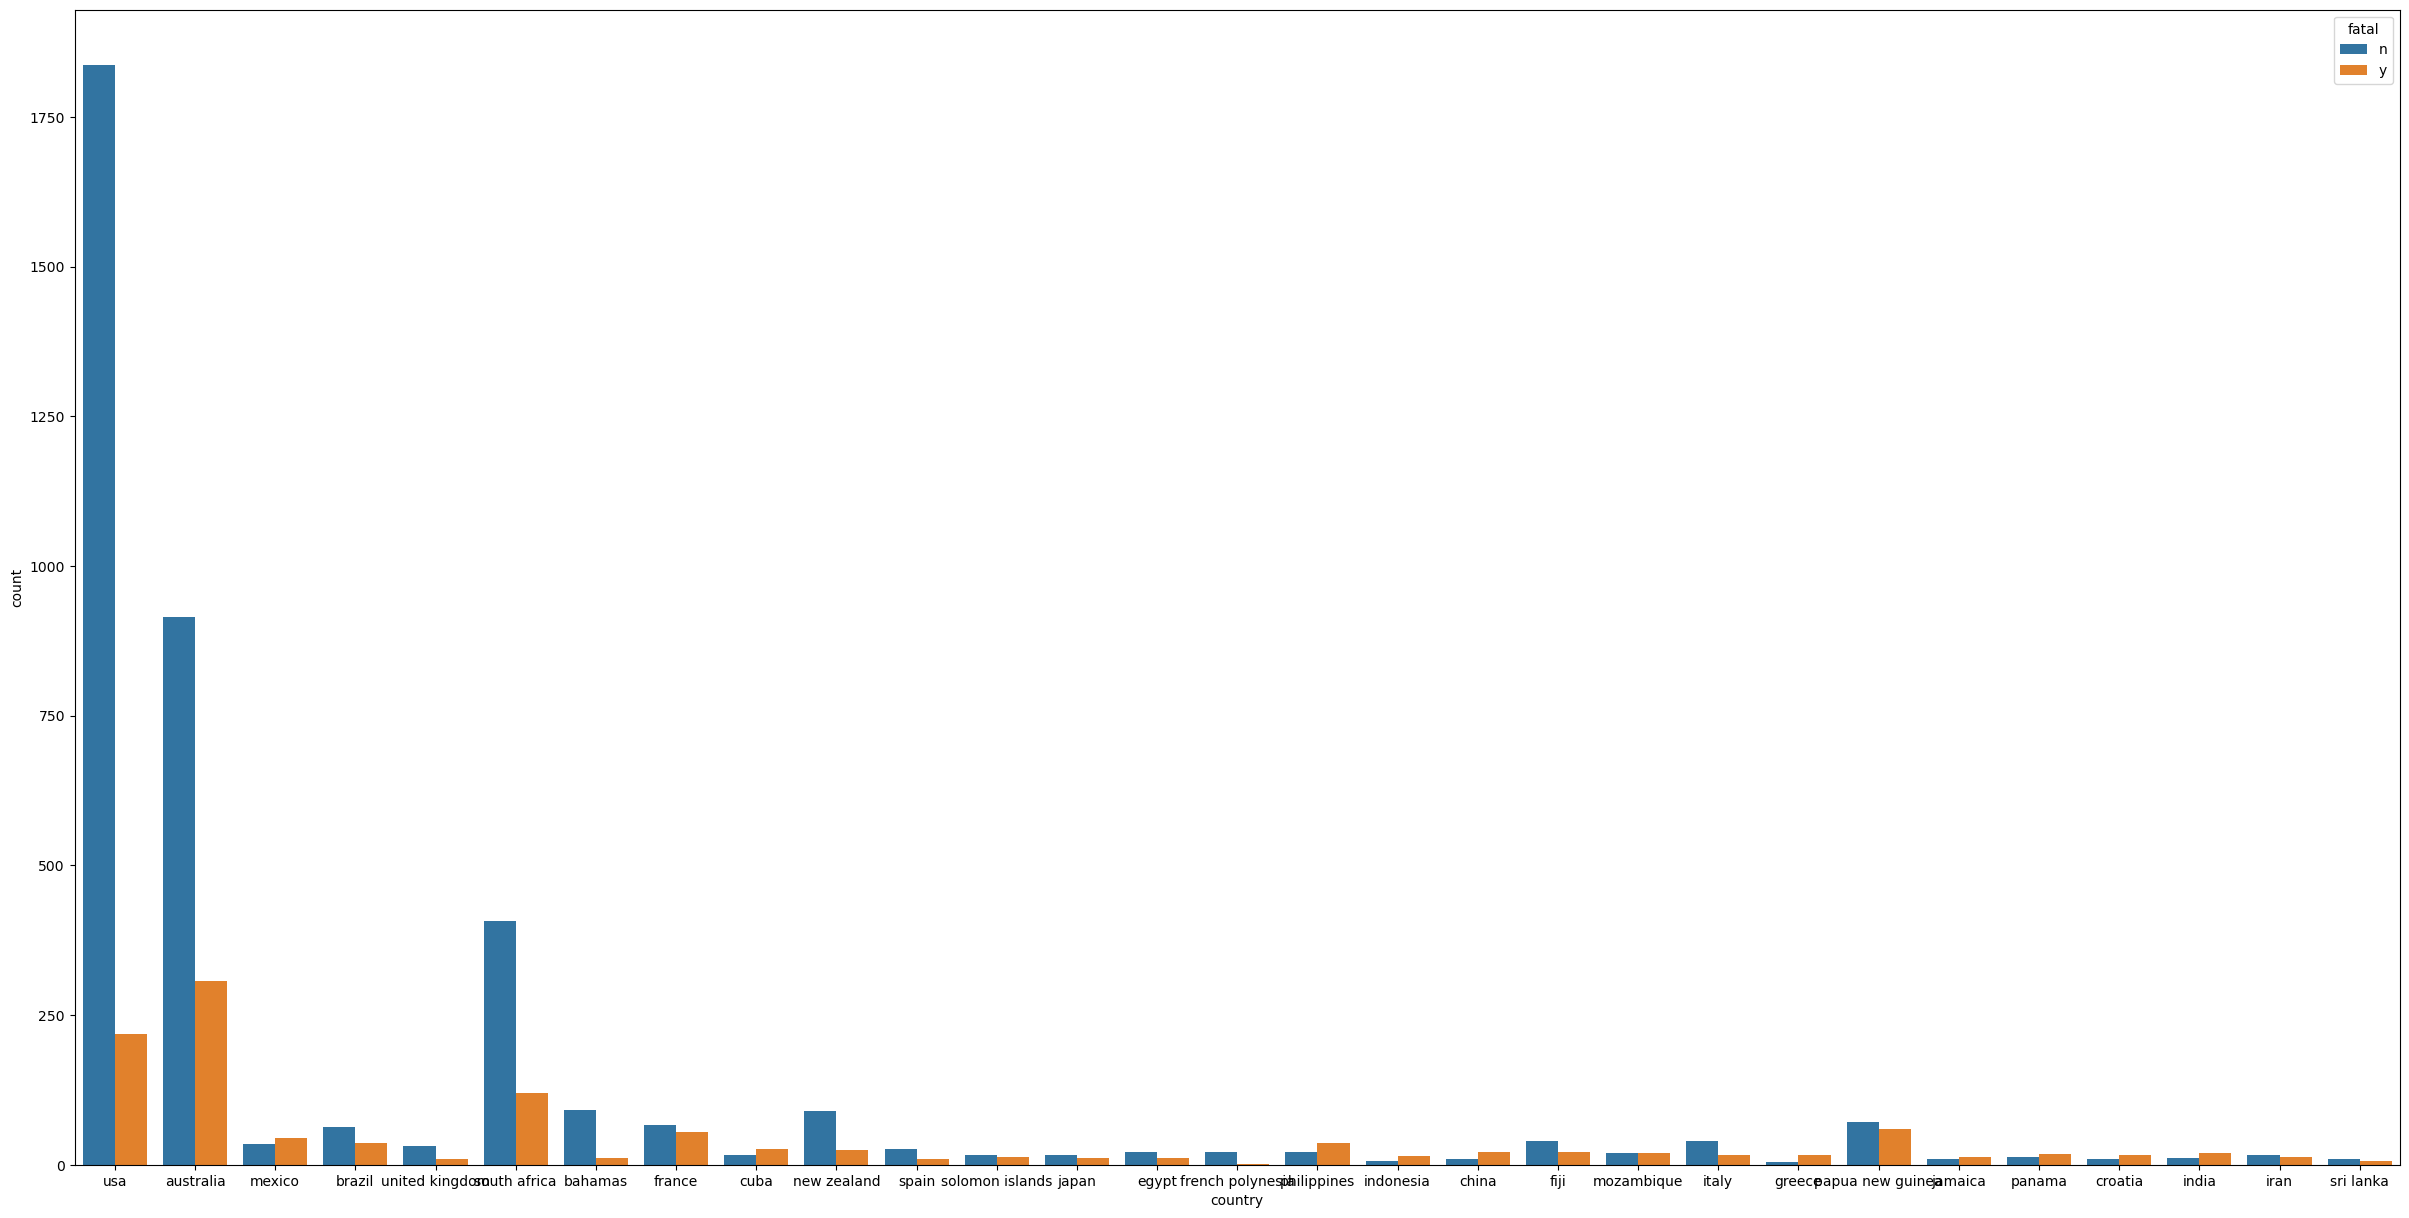

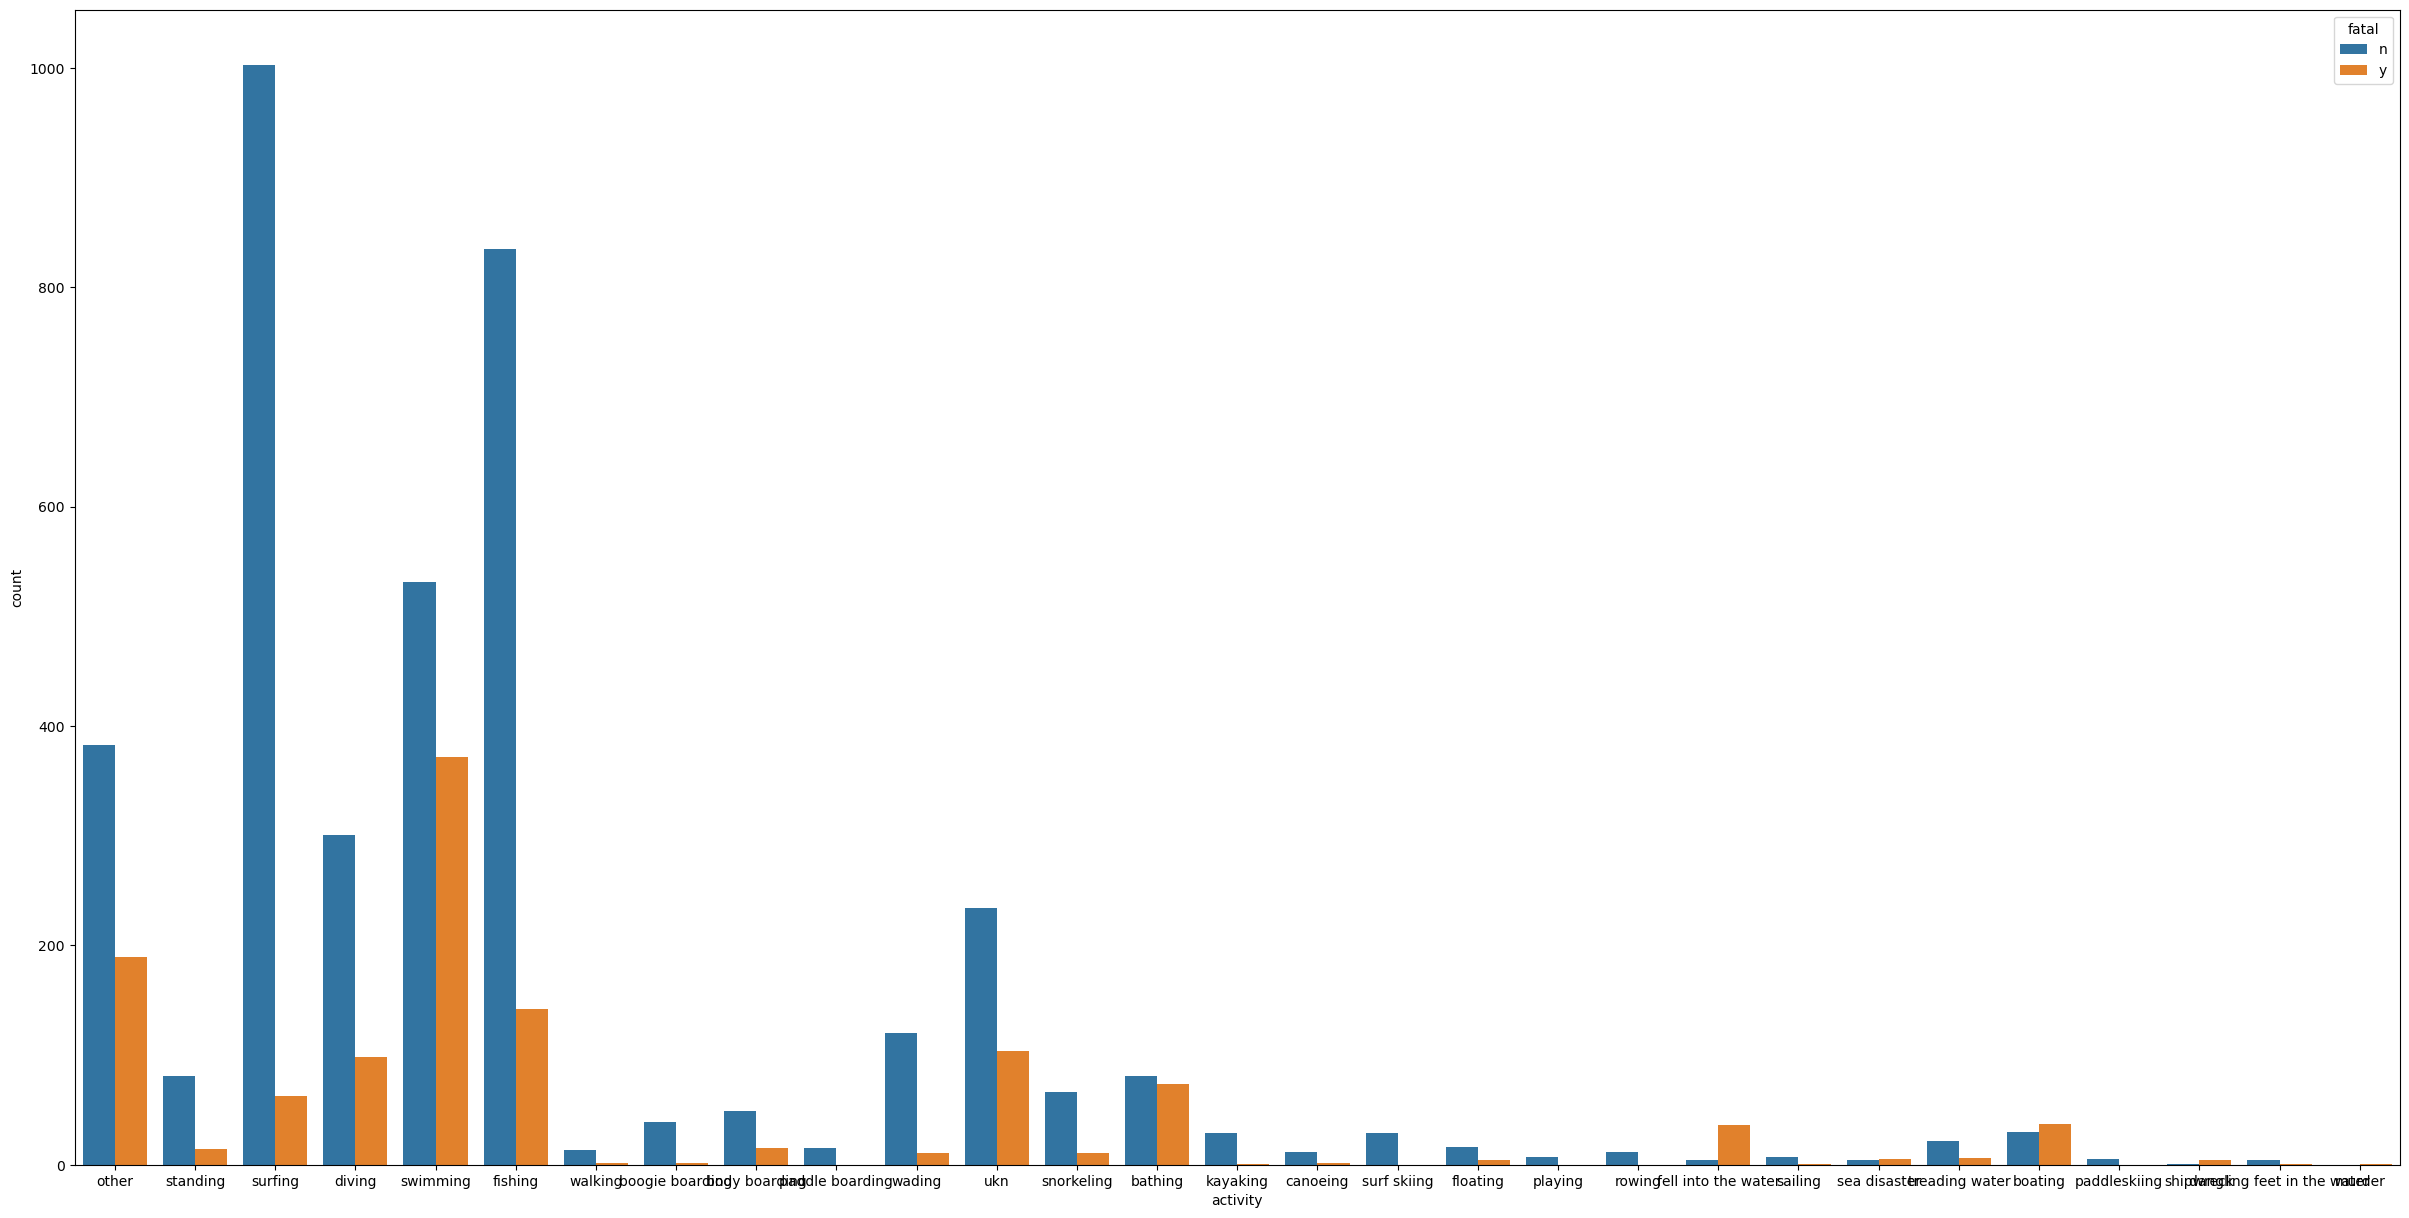

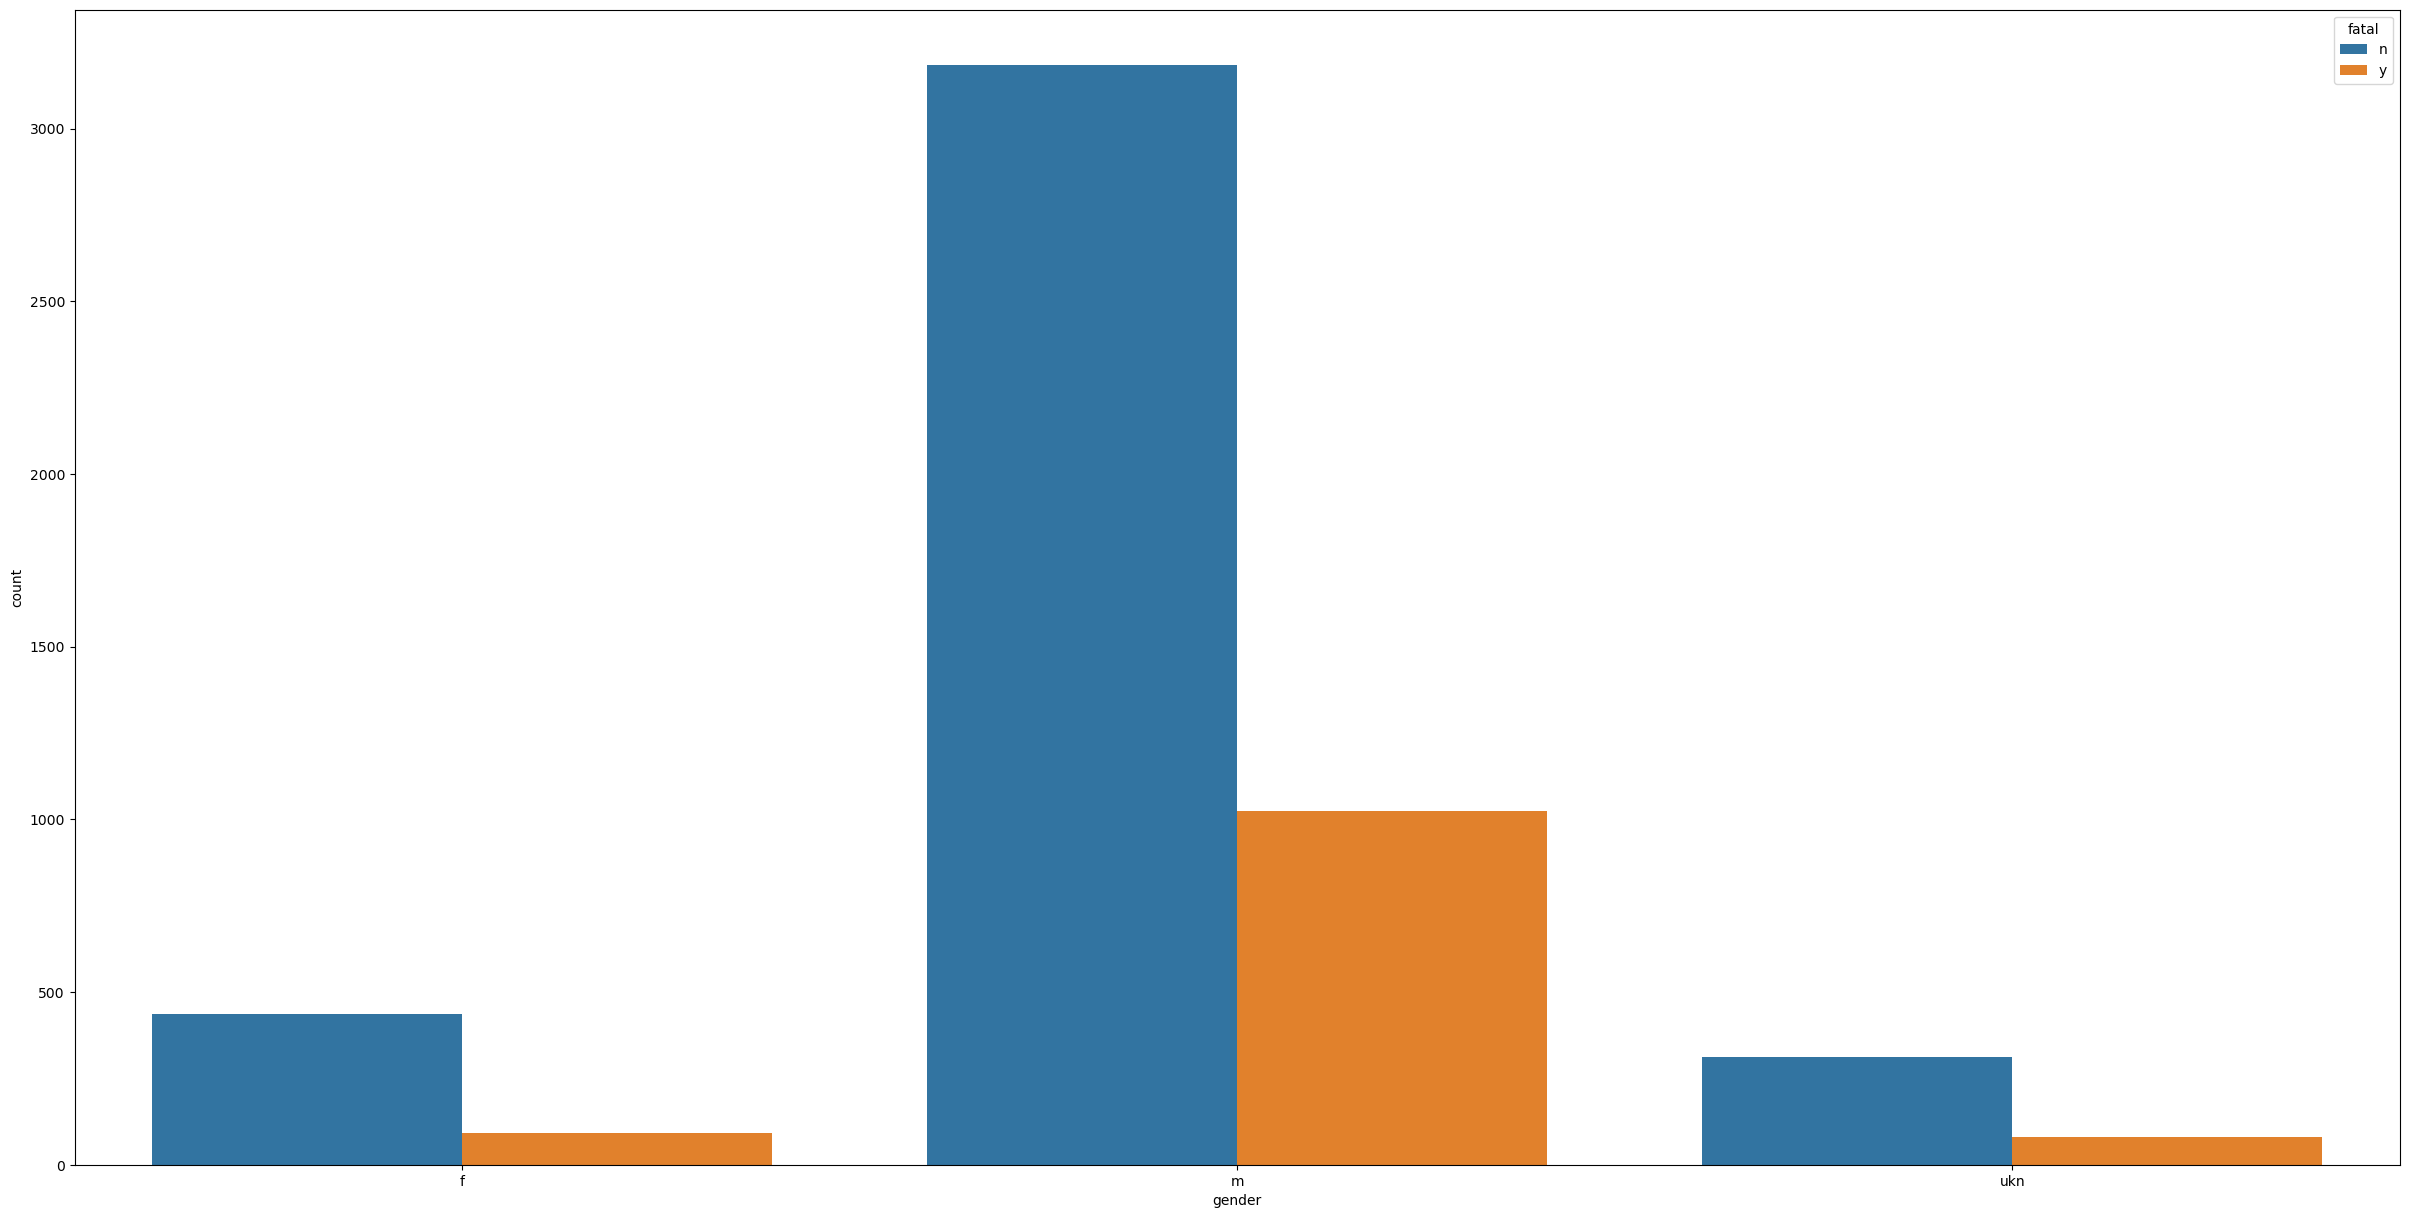

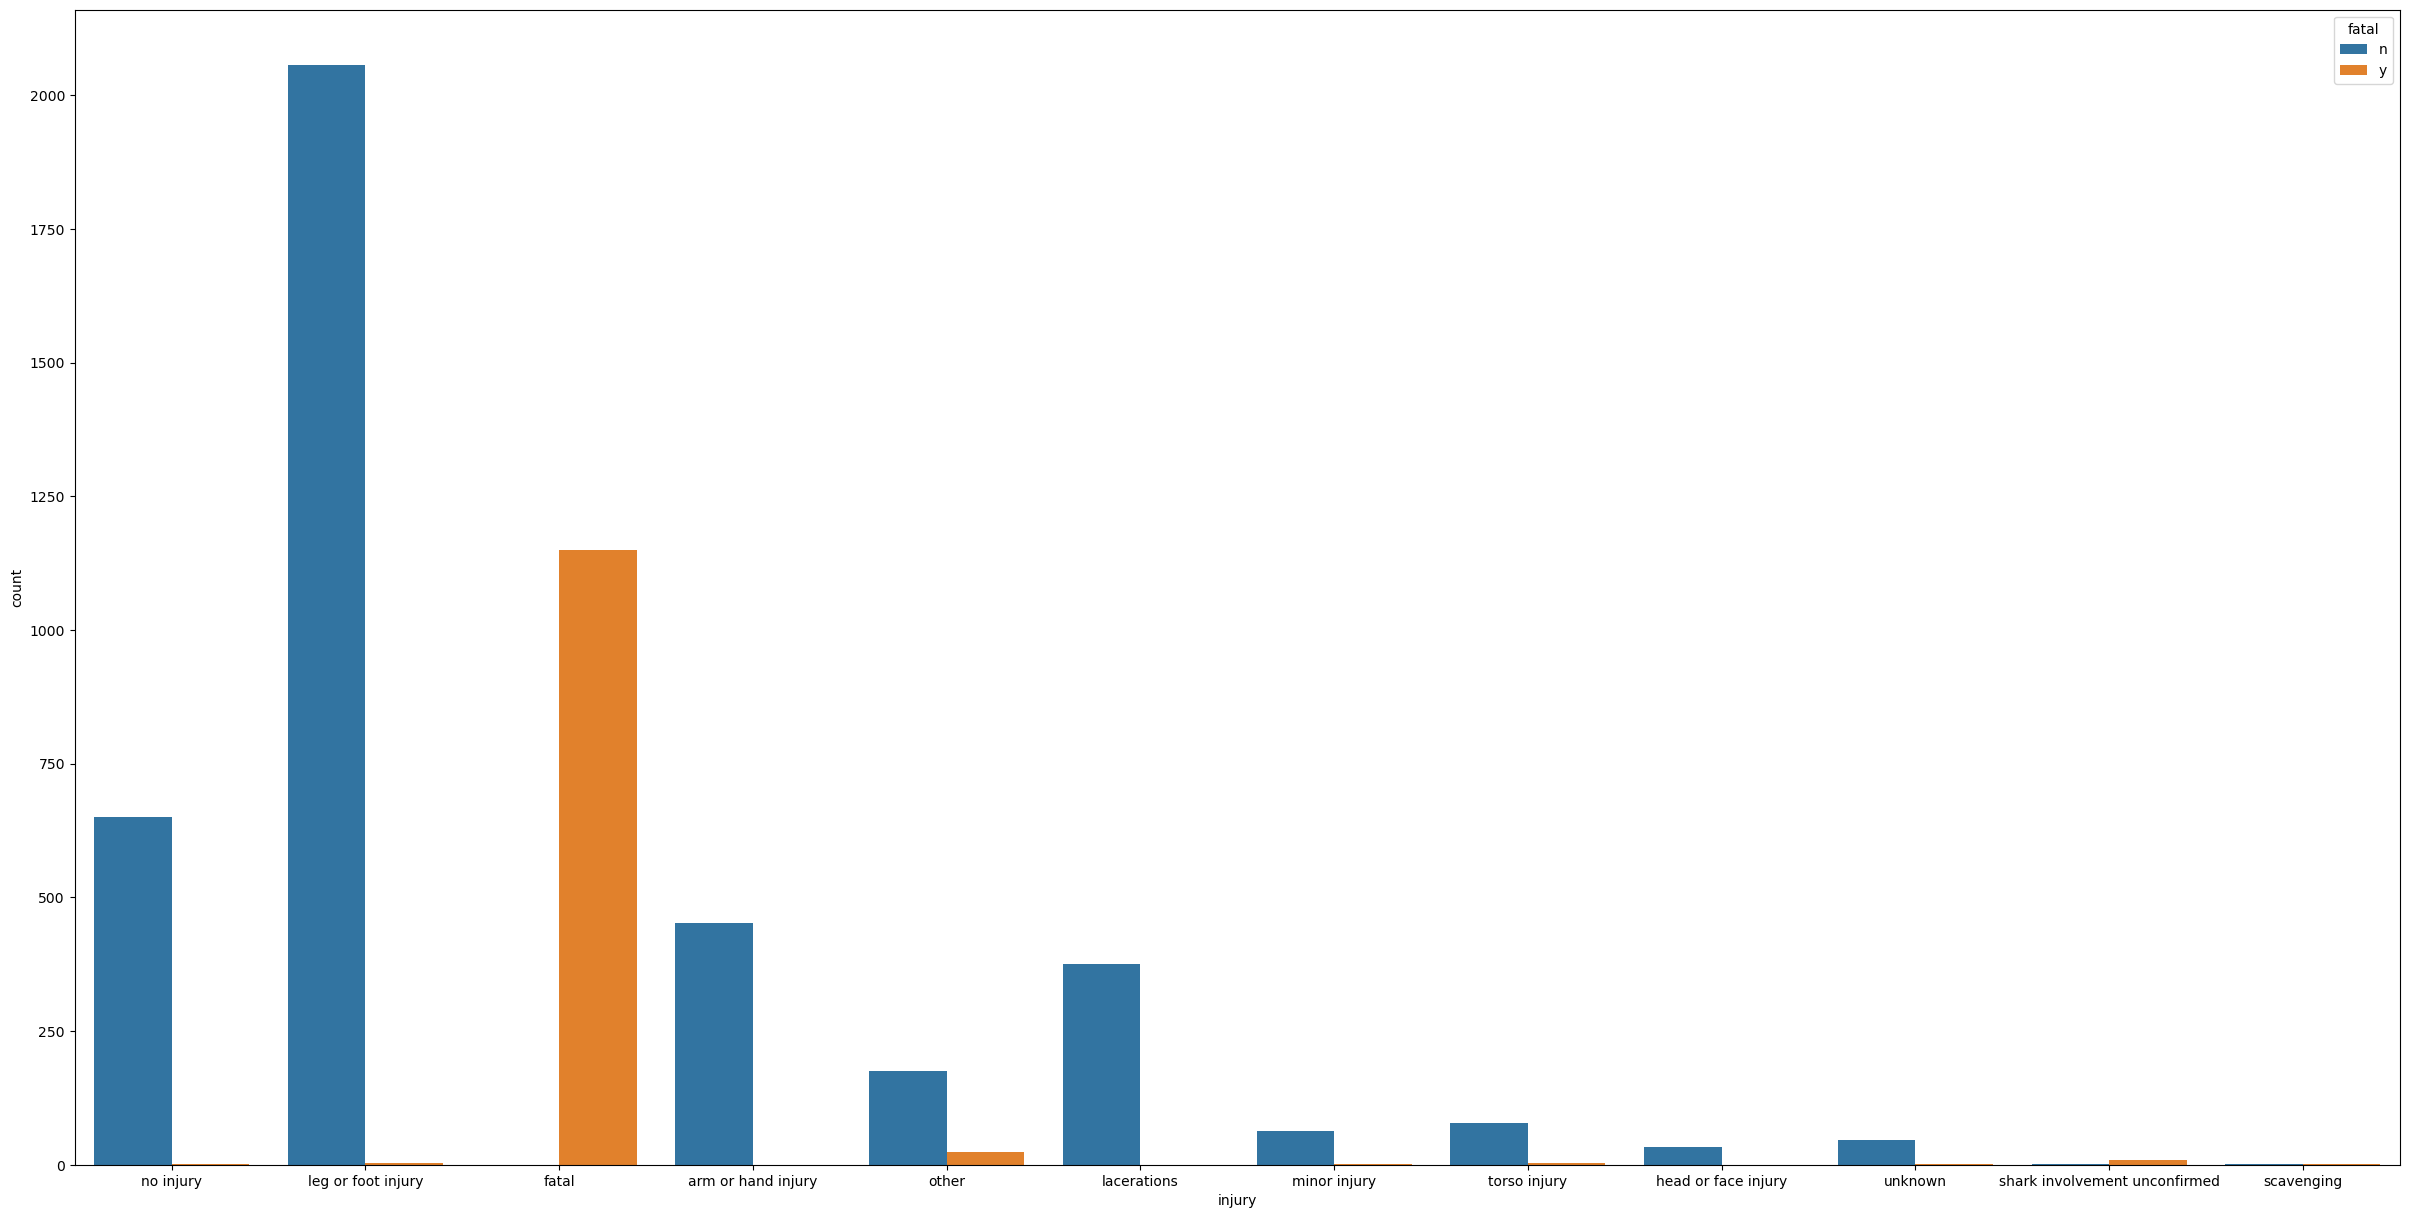

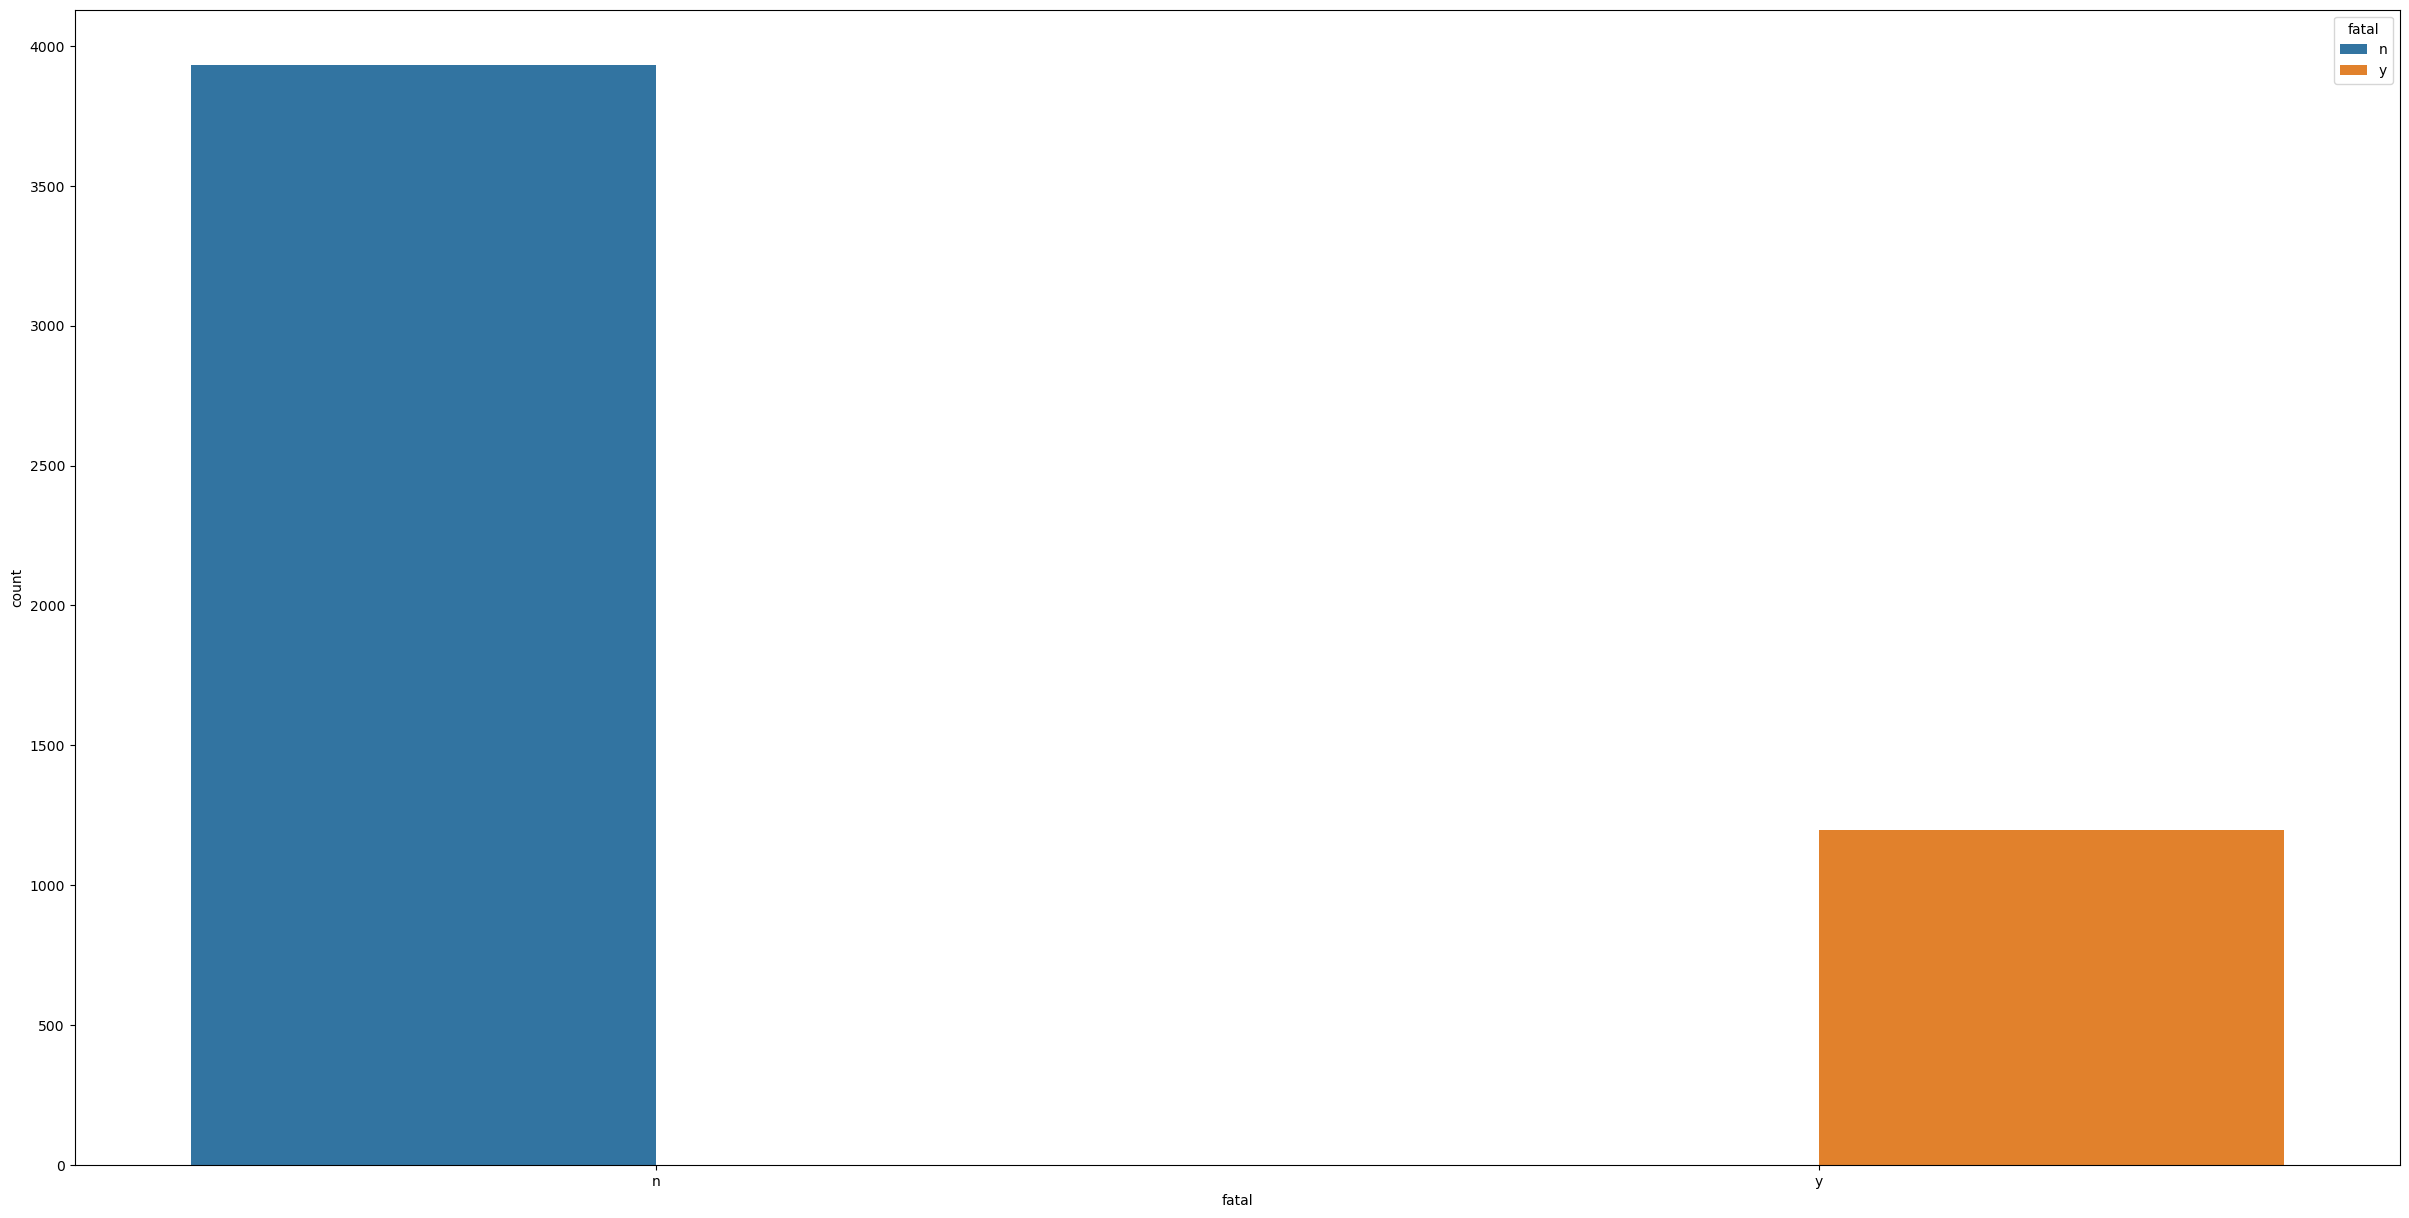

In [81]:
for col in data_final.columns:
    plt.figure(figsize=(30,15))
    sns.countplot(x= col, hue="fatal", data=data_final)
    plt.show()

### Contingency table

In [82]:
for col in data_final:
    contingency_table = pd.crosstab(data_final[col], data_final["fatal"])
    row_sums = contingency_table.sum(axis=1)
    col_sums = contingency_table.sum(axis=0)
    contingency_table["y"] = contingency_table["y"] / contingency_table["y"].sum() *100
    contingency_table["n"] = contingency_table["n"] / contingency_table["n"].sum() *100
    display(contingency_table)

fatal,n,y
country,,
australia,23.264683,25.690377
bahamas,2.339181,0.920502
brazil,1.601831,3.096234
china,0.228833,1.841004
croatia,0.254259,1.422594
cuba,0.406814,2.175732
egypt,0.533944,1.004184
fiji,0.991609,1.841004
france,1.678108,4.518828


fatal,n,y
activity,,
bathing,2.059497,6.192469
boating,0.762777,3.096234
body boarding,1.245868,1.255230
boogie boarding,0.991609,0.167364
canoeing,0.305111,0.167364
dangling feet in the water,0.101704,0.083682
diving,7.653191,8.200837
fell into the water,0.101704,3.012552
fishing,21.230613,11.882845


fatal,n,y
gender,,
f,11.060259,7.698745
m,80.981439,85.690377
ukn,7.958302,6.610879


fatal,n,y
injury,,
arm or hand injury,11.492499,0.000000
fatal,0.000000,96.150628
head or face injury,0.839054,0.000000
lacerations,9.560132,0.000000
leg or foot injury,52.301042,0.334728
minor injury,1.601831,0.083682
no injury,16.526824,0.083682
other,4.474956,1.924686
scavenging,0.025426,0.167364


fatal,n,y
fatal,,
n,100.0,0.0
y,0.0,100.0


## Data processing

In [83]:
y = data_final['fatal']
X = data_final.drop('fatal', axis=1)

In [84]:
X = pd.get_dummies(X, columns=['country', 'activity', 'gender', 'injury']) #dummifying the data (as we have only categorical data)
X

,country_australia,country_bahamas,country_brazil,country_china,country_croatia,country_cuba,country_egypt,country_fiji,country_france,country_french polynesia,...,injury_head or face injury,injury_lacerations,injury_leg or foot injury,injury_minor injury,injury_no injury,injury_other,injury_scavenging,injury_shark involvement unconfirmed,injury_torso injury,injury_unknown
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6297,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6298,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6299,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
pd.get_dummies(data_final).corr()["fatal_y"].sort_values()

fatal_n                        -1.000000
injury_leg or foot injury      -0.448097
country_usa                    -0.244822
activity_surfing               -0.210764
injury_no injury               -0.208808
                                  ...   
activity_bathing                0.102055
activity_fell into the water    0.139882
activity_swimming               0.195662
injury_fatal                    0.974880
fatal_y                         1.000000
Name: fatal_y, Length: 75, dtype: float64

In [86]:
pd.get_dummies(data_final).corr()["fatal_n"].sort_values()

fatal_y                        -1.000000
injury_fatal                   -0.974880
activity_swimming              -0.195662
activity_fell into the water   -0.139882
activity_bathing               -0.102055
                                  ...   
injury_no injury                0.208808
activity_surfing                0.210764
country_usa                     0.244822
injury_leg or foot injury       0.448097
fatal_n                         1.000000
Name: fatal_n, Length: 75, dtype: float64

### Logistic Regression model

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [89]:
classification = LogisticRegression(random_state=42) # modeling

classification.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [90]:
classification.score(X_test, y_test)

0.9883040935672515

In [91]:
predictions = classification.predict(X_test) # getting the predictions
predictions

array(['n', 'y', 'n', ..., 'n', 'y', 'n'], dtype=object)

In [92]:
y_test.value_counts()

n    776
y    250
Name: fatal, dtype: int64

In [93]:
predictions_ = classification.predict_proba(X_test) # checking the probabilities of predictions
predictions_

array([[9.89656269e-01, 1.03437313e-02],
       [1.47629443e-02, 9.85237056e-01],
       [9.37431175e-01, 6.25688250e-02],
       ...,
       [9.99243861e-01, 7.56139454e-04],
       [3.04162756e-02, 9.69583724e-01],
       [9.85319417e-01, 1.46805831e-02]])

In [94]:
confusion_matrix(y_test, predictions)

array([[774,   2],
       [ 10, 240]], dtype=int64)

<Axes: >

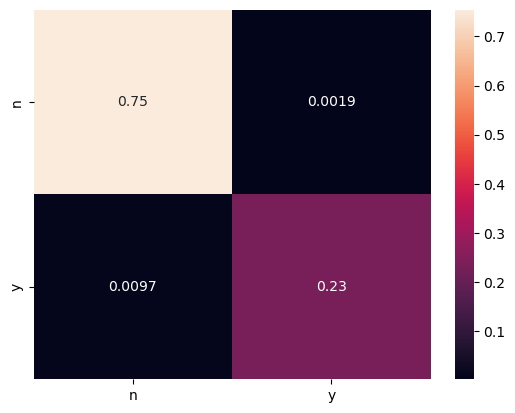

In [95]:
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
sns.heatmap(cf_matrix, annot=True, xticklabels=["n", "y"], yticklabels=["n", "y"])

In [96]:
# our dataframe contains way more values for 'n' than for 'y', so the model is mostly guessing that the attack won't be fatal. 

### Data balancing to improve the accuracy of the model

In [97]:
! pip install imblearn

In [98]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train) 
y_train_balanced.value_counts()

n    3157
y    3157
Name: fatal, dtype: int64

In [99]:
classification = LogisticRegression(random_state=42) 
classification.fit(X_train_balanced, y_train_balanced)
classification.score(X_test, y_test) 

0.9912280701754386

In [102]:
# score improved after balancing data

<Axes: >

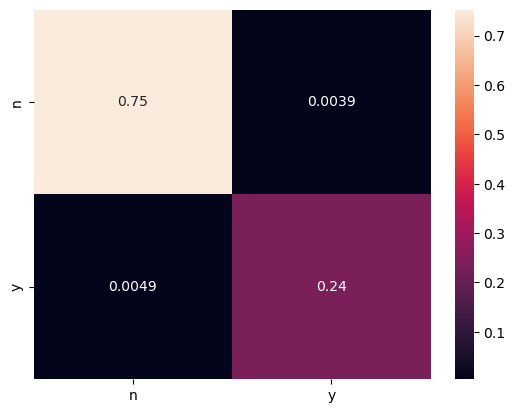

In [103]:
predictions = classification.predict(X_test) #checking predictions after balanding the data
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
sns.heatmap(cf_matrix, annot=True, xticklabels=["n", "y"], yticklabels=["n", "y"])

In [104]:
#balancing the data made it slightly more likely for the model to predict that the attach will be fatal